In [37]:
### Import packages ###
import time, sys, os
import h5py
import numpy as np
import astropy as ap
import scipy
import pandas
from matplotlib.pyplot import *

# Import packages to display SDSS optical image
from PIL import Image
import requests

# Import packages to open fits and calculate cosmology
from astropy.io import fits
from astropy.cosmology import WMAP9
import astropy.coordinates as coord
from astroquery.sdss import SDSS
from scipy.io import readsav

# Import prospector 
sys.path.insert(0, '/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/')
import prospect     #likelihood evaluations, parameter priors, and posterior sampling
from prospect.models.templates import TemplateLibrary
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log
from prospect.likelihood import chi_spec, chi_phot
from prospect.fitting import fit_model
from prospect.io import write_results as writer
import prospect.io.read_results as reader

# Import MCMC package
import emcee

# Import my build functions
from build_model_funct import build_model
from build_obs_funct import build_obs
from FracSFH_ import FracSFH

### re-defining plotting defaults for matplotlib
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})
rcParams.update({'axes.facecolor':'w'})
rcParams.update({'savefig.facecolor':'w'})
rcParams.update({'lines.linewidth':'0.7'})

%matplotlib inline

### package versions ###
# vers = (np.__version__, scipy.__version__, h5py.__version__, fsps.__version__, prospect.__version__)
# print("numpy: {}\nscipy: {}\nh5py: {}\nfsps: {}\nprospect: {}".format(*vers))

In [38]:
### Start Timer ###
start_time = time.time()

In [39]:
### Constants ###
lsun = 3.846e33
pc = 3.085677581467192e18 # in cm
lightspeed = 2.998e18 # AA/s
to_cgs = lsun/(4.0 * np.pi * (pc*10)**2)
jansky_mks = 1e-26

### My Unit Functions ###
def mJy_to_maggies(mJy):
    """ Converts mJy to maggies
    """
    conversion_mJy_Jy = .001
    conversion_mJy_maggie = 3631
    return mJy * conversion_mJy_Jy/conversion_mJy_maggie

def f_nu_to_f_lambda_maggie(lam, f_nu):
    """ Converts f_nu (ergs) to f_lambda (maggies)
    """
    f_lambda_ergs = (10**-17 * f_nu) * (lam**2)/lightspeed
    f_lambda_mJy = (f_lambda_ergs / (1E-23)) * 1000
    f_lambda_maggie = mJy_to_maggies(f_lambda_mJy)
    return f_lambda_maggie

### From GitHub ###
def get_best_v2(res, **kwargs):
    """ Get the maximum a posteriori parameters.
    """
    imax = np.argmax(res['lnprobability'])
    try:
        i, j = np.unravel_index(imax, res['lnprobability'].shape)
        theta_best = res['chain'][i, j, :].copy()
    except(ValueError):
        theta_best = res['chain'][imax, :].copy()
        
    return  theta_best

def build_sps(zcontinuous=1, **extras):
    """ Build sps object using FracSFH basis
    """
    sps = FracSFH(zcontinuous = 1, **extras)         # run_params
    return sps

In [40]:
### Import full galaxy file (58 galaxies) ###
AGN_file = fits.open('/mnt/c/Users/emma_d/ASTR_Research/Data/asu.fit')
AGN_data = AGN_file[1].data

In [41]:
### Choose a galaxy (0 to 57) ###
galaxy_num = 13
Template_Type = 'alpha_agn'

# Create galaxy file to store plots and hdf5 data file
if not os.path.exists('Galaxy_output/G{}/'.format(galaxy_num)):
    os.mkdir('Galaxy_output/G{}/'.format(galaxy_num))
Galaxy_Path = 'Galaxy_output/G{}/'.format(galaxy_num)

print('This is for Galaxy ', galaxy_num + 1)

ts = time.strftime("%y%b%d", time.localtime())
print('The Date is', ts)
print('The template type is', Template_Type)

This is for Galaxy  14
The Date is 21Jun22
The template type is alpha_agn


In [42]:
### Query SDSS to get optical spectra data ###
#   Used tutorial from 
#       https://learn.astropy.org/rst-tutorials/User-Defined-Model.html 
#       http://astroweb.case.edu/jakub/TA/Interpolation.html 

# Pull RA, DEC from data file and query SDSS
Gal_RA, Gal_DEC = AGN_data[galaxy_num][2], AGN_data[galaxy_num][3]
pos = coord.SkyCoord(Gal_RA, Gal_DEC, unit='deg',frame='icrs')
xid = SDSS.query_region(pos, spectro=True)
xid

/home/emma/.local/lib/python3.8/site-packages/astroquery/sdss/core.py:862: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


<Table length=1>
       ra              dec               objid        ... run2d instrument
    float64          float64             int64        ... int64   bytes4  
---------------- ---------------- ------------------- ... ----- ----------
184.260121435805 39.0770342365286 1237664667371569288 ...    26       SDSS

In [43]:
### Redshift ###
G_Redshift = xid['z'][0]                                    # Use redshift from SDSS query

cosmo = ap.cosmology.FlatLambdaCDM(H0=70, Om0=0.3)          # cosmological redshift object
ldist_Mpc_units = cosmo.comoving_distance(G_Redshift)       # cosmological redshift

ldist_Mpc = ldist_Mpc_units.value                           # Get ldist in Mpc from ldist with units
tage_of_univ = WMAP9.age(G_Redshift).value                  # age of the universe in Gyr

In [44]:
### Get optical spectrum from SDSS query ###
optical_spectrum = SDSS.get_spectra(plate= xid['plate'][0], fiberID= xid['fiberID'][0], mjd= xid['mjd'][0])[0] 

[O_II] 3727  -> [3729.875448]
[O_III] 5007  -> [5008.23963773]
H_alpha  -> [6564.61389433]


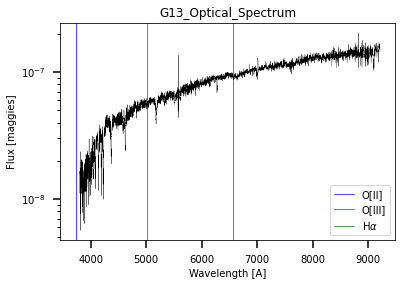

In [45]:
### Plot optical spectrum ###
optical_spectrum_flux = optical_spectrum[1].data['flux']
optical_spectrum_lam = 10 ** (optical_spectrum[1].data['loglam'])

# Spectra lines for OII, OIII, Halpha
optical_spectrum_lines = optical_spectrum[3].data
for n in ['[O_II] 3727', '[O_III] 5007', 'H_alpha']:
    print(n, " ->", optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']==n])
axvline(x=optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']=='[O_II] 3727'], label=r'O[II]', color='blue')
axvline(x=optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']=='[O_III] 5007'], label=r'O[III]', color='red')
axvline(x=optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']=='H_alpha'], label=r'H$\alpha$', color='green')

# Find what units the data is in
units_flux = optical_spectrum[0].header['bunit']
units_wavelength_full = optical_spectrum[0].header['WAT1_001']
units_wavelength = units_wavelength_full[36:]

# Convert SDSS units to Prospector units
optical_spectrum_flux = f_nu_to_f_lambda_maggie(optical_spectrum_lam, optical_spectrum_flux)

# Plot the spectra
plot(optical_spectrum_lam, optical_spectrum_flux, color='k', linewidth=.3)
xlabel('Wavelength [A]')
ylabel('Flux [maggies]')
title('G{0}_Optical_Spectrum'.format(galaxy_num))
yscale('log')
legend()

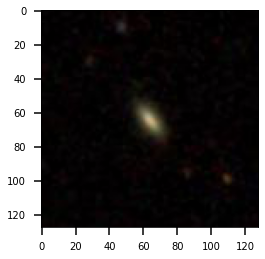

In [46]:
### Get optical image from the url using galaxy RA and DEC ###
SDSS_URL = 'http://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getjpeg?TaskName=Skyserver.Chart.List&ra={0}&dec={1}'.format(Gal_RA, Gal_DEC)

SDSS_Image = Image.open(requests.get(SDSS_URL, stream=True).raw)
imshow(SDSS_Image)

In [47]:
### Spitzer IRS data from Dr. Smercina ###
ea_struct = readsav('Data/ea_struct_v9.sav')['ea_struct']
# ea_struct.dtype.names                                     # Keys in ea_struct

In [48]:
gal_EA_Desig = AGN_data[galaxy_num][1][2:]
s1, = np.where(ea_struct.source.astype(str) == 'Spitzer')       # Pulls only spitzer from sources
ea_struct = ea_struct[s1]                                       # Masks ea_struct to get spitzer

# If the IRS data contains the galaxy, graph the IRS data. If not print there is no IRS data.
if gal_EA_Desig in ea_struct['EA_DESIG'].astype(str):
    IRS_indicator = 1                                           # Indicates there is IRS data
    print('There is Spitzer IRS spectrum data for this galaxy')
    s, = np.where(ea_struct.ea_desig.astype(str) == gal_EA_Desig)

    # Convert Smercina units (mu*m,nu*f_nu) to prospector units (A, maggies)
    IRS_wavelength = ea_struct[s][0].irs_spectrum.wave * 10000
    IRS_flux = mJy_to_maggies(10**13 *(ea_struct[s][0].irs_spectrum.wave/(2.998*10**14)) * ea_struct[s][0].irs_spectrum.flux)

    # Masks where IRS_FLUX is very low (~= 0) : Keeps dips to 0 out of plot
    IRS_wavelength =IRS_wavelength[ IRS_flux > 10**-9 ]
    IRS_flux = IRS_flux[ IRS_flux > 10**-9 ]

    # Plot IRS data
    plot(IRS_wavelength, IRS_flux)
    xlabel('Wavelength [A]')
    ylabel('Flux [maggie]')
    title('G{0}_IRS_Spectrum'.format(galaxy_num))
    yscale('log')

else:
    IRS_indicator = 0                                           # Indicates there is no IRS data
    print('There is no Spitzer IRS spectrum data for this galaxy')

print('This is galaxy', gal_EA_Desig, galaxy_num)

There is no Spitzer IRS spectrum data for this galaxy
This is galaxy H05 13


In [49]:
### Create run_params dictionary ###
run_params = { 'ldist': ldist_Mpc,
                'agelims': [0.0,8.0,8.5,9.0,9.5,9.8,10.0],
                'object_redshift': G_Redshift,
                'zcontinuous': 1,                           # Leja: 2
                'verbose': False,                           # Leja: True
                'dynesty': False,                           
                'emcee': False,                             
                'optimize': False,                          
                'optimization': False,
                'min_method': 'lm',
                'nmin': 5,                                  # initially 2, can try 1
                'nwalkers': 128,                            # Leja: 620
                'niter': 512,                               # Leja: 7500
                'nburn': [16, 32, 64],                      # Leja: [150, 200, 200]
                'optimization': False,
                'nested_method': 'rwalk',
                'nlive_init': 400,
                'nlive_batch': 200,
                'nested_dlogz_init': 0.05,
                'nested_posterior_thresh': 0.05,
                'nested_maxcall': int(1e7),

                # From Leja:
                'objname': 'G{0}_{1}'.format(galaxy_num, Template_Type),
                'initial_disp': 0.1,

                'AGN_switch': True,
                'tage_of_univ': tage_of_univ,
                'Template_Type': Template_Type,
                'galaxy_num': galaxy_num,
                'IRS_indicator': IRS_indicator,
                'SDSS_Query': xid

                # 'nofork': True,
                # 'ftol': 0.5e-5
                # 'maxfev': 5000,
                # 'interval': 0.2,
                # 'convergence_check_interval': 50,
                # 'convergence_chunks': 325,
                # 'convergence_kl_threshold': 0.016,
                # 'convergence_stable_points_criteria': 8, 
                # 'convergence_nhist': 50,
                # 'compute_vega_mags': False,
                # 'interp_type': 'logarithmic',
                }

In [50]:
### Built obs dict using meta-params ###
obs = build_obs(**run_params)

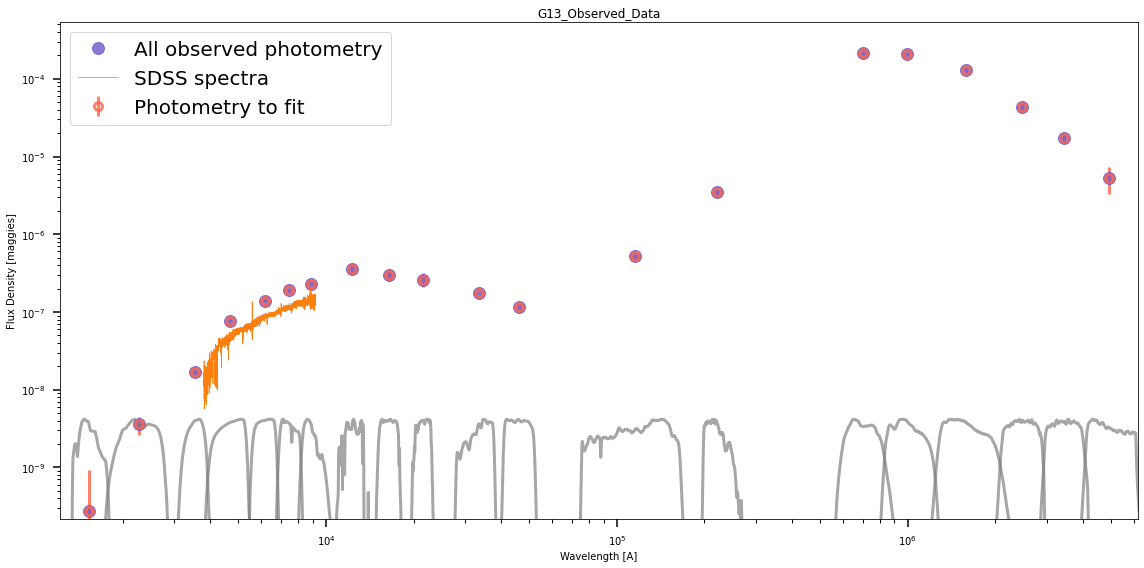

In [51]:
### Plot all observed data ###
# Retreive observed photometry and photometry mask from obs
wphot = obs["phot_wave"]
mask = obs["phot_mask"]

# Set minimum and maximum limits for plot
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"][mask].min()*0.8, obs["maggies"][mask].max()/0.4  
figure(figsize=(16,8))

# Plot all observed photometry
plot(wphot, obs['maggies'],
     label='All observed photometry',
     marker='o', markersize=12, alpha=0.8, ls='', lw=3,
     color='slateblue')

# Overplot only data we want to fit (using phot_mask)
errorbar(wphot[mask], obs['maggies'][mask], 
         yerr=obs['maggies_unc'][mask], 
         label='Photometry to fit',
         marker='o', markersize=8, alpha=0.8, ls='', lw=3,
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# Plot filter bands
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Plot optical and IRS data if available
plot(optical_spectrum_lam, optical_spectrum_flux, label='SDSS spectra')
if IRS_indicator == 1:
    plot(IRS_wavelength, IRS_flux, label='IRS spectra')

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
xscale("log")
yscale("log")
legend(loc='best', fontsize=20)
title('G{0}_Observed_Data'.format(galaxy_num))
tight_layout()

In [52]:
# Use PolySpec model to match mismatched photometry/spectroscopy:
#       https://github.com/bd-j/prospector/issues/213

In [53]:
### Define agelimits, tilde_alpha, and z_fraction_init for build_model ###
agelims = run_params['agelims']
agelims[-1] = np.log10(tage_of_univ * 1e9)
agebins = np.array([agelims[:-1], agelims[1:]])
ncomp = agebins.shape[1]                              #- 1 Had to modify for array sizes to fit

tilde_alpha = np.array([ncomp - i for i in list(range(1, ncomp))])
z_fraction_init = np.array([(i-1)/float(i) for i in range(ncomp,1,-1)])

# Save prospector compatible arrays to run_params
run_params['ncomp'] = ncomp
run_params['agebins_init'] = agebins.T
run_params['tilde_alpha'] = tilde_alpha
run_params['z_fraction_init'] = z_fraction_init

In [54]:
### Build model and view model ###
model = build_model(**run_params)

# Save number of free parameters and number of data points to run_params
run_params['num_free_params'] = len(model.free_params)
run_params['free_params'] = model.free_params 
run_params['num_data_points'] = len(obs['maggies'][obs["phot_mask"]])

In [55]:
### Build sps object using FracSFH basis ###
sps = build_sps(**run_params)

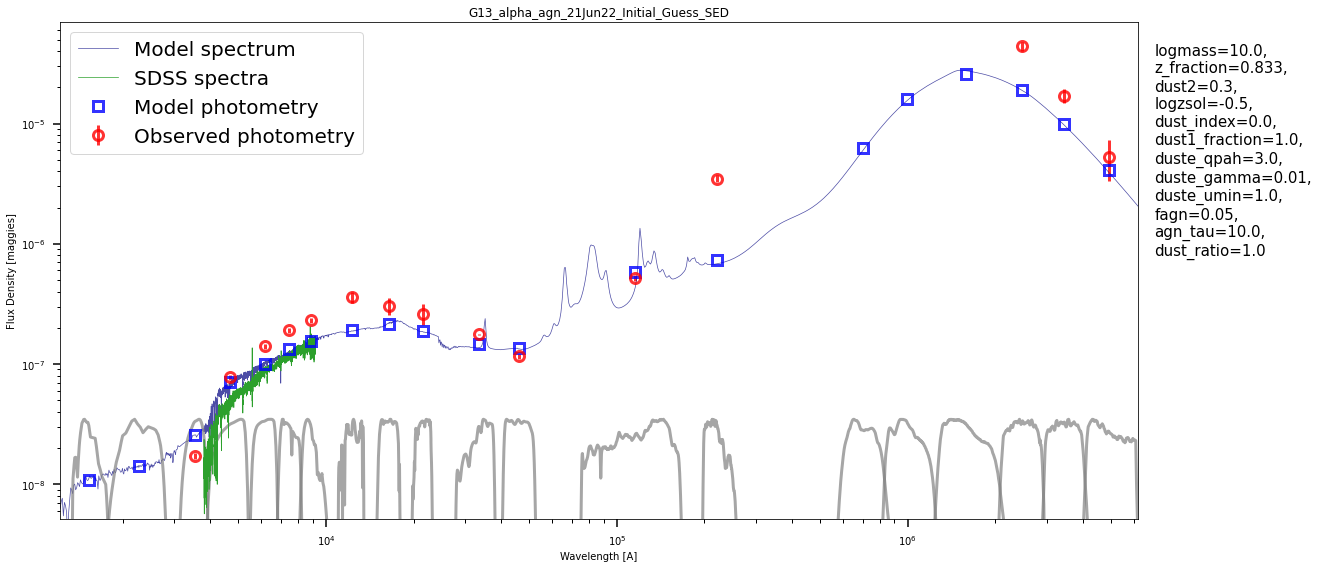

In [56]:
### View Model ###
### prediction for the data from any set of model params ###

### Generate the model SED with the 'init' parameter values in model
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)
title_text = ','.join(["\n{}={:.3}".format(p, model.params[p][0]) 
                       for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
wphot = obs["phot_wave"]                # photometric effective wavelengths

# spectroscopic wavelengths
# *restframe* spectral wavelengths, since obs["wavelength"] is None
wspec = sps.wavelengths
wspec *= a                                          # redshift them

xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4
figure(figsize=(16,8))

# Plot model and data
loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# Place text of all initial model values and title
figtext(1.005, .55, title_text, ha="left", fontsize=15)
title('G{0}_{1}_{2}_Initial_Guess_SED'.format(galaxy_num, Template_Type, ts))

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Plot optical and IRS data if available
plot(optical_spectrum_lam, optical_spectrum_flux, label='SDSS spectra')
if IRS_indicator == 1:
    plot(IRS_wavelength, IRS_flux, label='IRS spectra')

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

savefig(Galaxy_Path + 'G{0}_{1}_{2}_Initial_Guess_SED_2'.format(galaxy_num, Template_Type, ts))

In [57]:
### Likelyhood Function ###
"""
For nested sampling lnprobfn(theta, nested=True) will return the likelihood (since the prior probability is accounted for by drawing proposals from the priors), while for other types of MCMC sampling lnprobfn(theta, nested=False) returns the posterior probability.
"""
# Turn off AGN parameters so that all galaxies can have a Xi2 prediction
run_params['AGN_switch'] = False

### Running Prospector ###
# Fit the model using chi squared minimization
# Ensemble MCMC sampler around best location from the minimization 

# Run all building functions
obs = build_obs(**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)

# For fsps based sources it is useful to know which stellar isochrone and spectral library
# print(sps.ssp.libraries)
# help(fit_model)

In [58]:
# TemplateLibrary.describe("alpha")             # Describe the template and parameters used

In [59]:
### Minimization ###
# Uses Levenberg-Marquardt, needed parameters in run_params
# requires a likelihood function that returns a vector of chi values
# imported lnprobfn function takes care of chi values to likelyhood

# --- start minimization ---- # 
run_params["emcee"] = False
run_params["optimize"] = True

output = fit_model(obs, model, sps, lnprobfn=prospect.fitting.lnprobfn, **run_params)
print("Done optmization in {}s".format(output["optimization"][1]))

/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/models/priors.py:104: RuntimeWarning: divide by zero encountered in log
  lnp = np.log(p)
Done optmization in 280.1084620952606s


In [60]:
# Turn AGN parameters back on
run_params['AGN_switch'] = True

# Re-run build functions with AGN
obs = build_obs(**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)

model.theta [10.          0.83333333  0.8         0.75        0.66666667  0.5
  0.3        -0.5         0.          1.          3.          0.01
  1.          0.05       10.          1.        ]
ind_best =  0
theta_best =  [ 1.00000000e+01  8.33333333e-01  8.00000000e-01  7.50000000e-01
  6.66666667e-01  5.00000000e-01  3.00000000e-01 -5.00000000e-01
  0.00000000e+00  1.00000000e+00  3.00000000e+00  1.00000000e-02
  1.00000000e+00  1.00000000e-04  5.00000000e+00  1.00000000e+00]


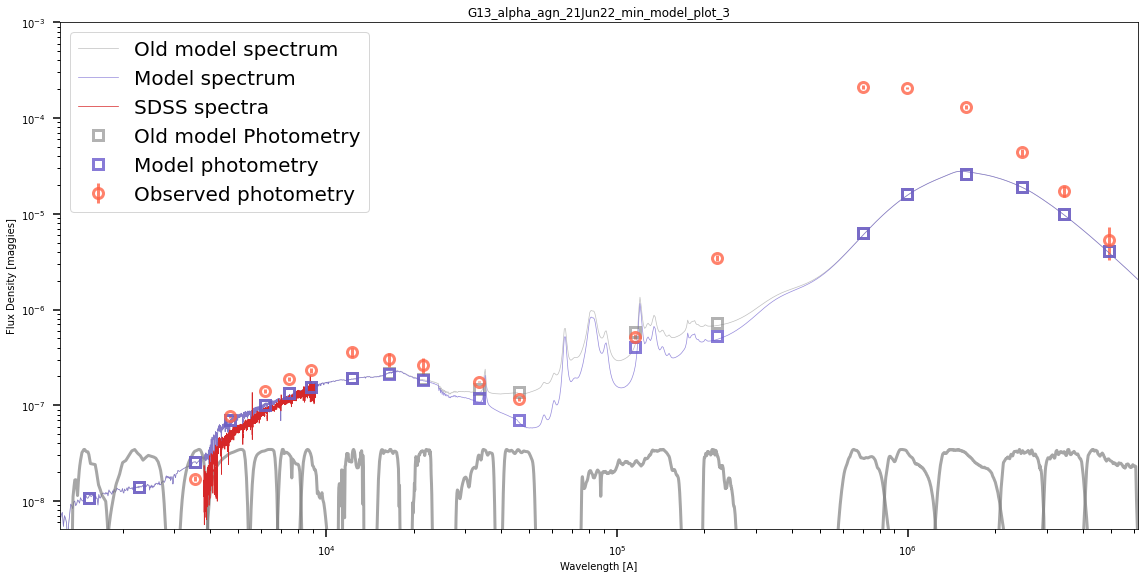

In [61]:
### Plot prediction SED with initial SED ###
print("model.theta", model.theta)
(results, topt) = output["optimization"]
# Find which of the minimizations gave the best result, 
#       and use the parameter vector for that minimization
ind_best = np.argmin([r.cost for r in results])
print("ind_best = ", ind_best)
theta_best = results[ind_best].x.copy()
print("theta_best = ", theta_best)

figure(figsize=(16,8))                       # Do NOT move

# Generate model prediction
prediction = model.mean_model(theta_best, obs=obs, sps=sps)
pspec, pphot, pfrac = prediction

# Plot flux data, prediction model, and old init model
loglog(wspec, initial_spec, label='Old model spectrum',
        lw=0.7, color='gray', alpha=0.5)
errorbar(wphot, initial_phot, label='Old model Photometry', 
        marker='s', markersize=10, alpha=0.6, ls='', lw=3, 
        markerfacecolor='none', markeredgecolor='gray', 
        markeredgewidth=3)
loglog(wspec, pspec, label='Model spectrum', 
        lw=0.7, color='slateblue', alpha=0.7) 
errorbar(wphot, pphot, label='Model photometry', 
        marker='s', markersize=10, alpha=0.8, ls='', lw=3,
        markerfacecolor='none', markeredgecolor='slateblue', 
        markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
        label='Observed photometry', 
        marker='o', markersize=10, alpha=0.8, ls='', lw=3, 
        ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
        markeredgewidth=3)

# Plot filter transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Plot optical and IRS data if available
plot(optical_spectrum_lam, optical_spectrum_flux, label='SDSS spectra')
if IRS_indicator == 1:
    plot(IRS_wavelength, IRS_flux, label='IRS spectra')

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ymax = 10**-3
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

title('G{0}_{1}_{2}_min_model_plot_3'.format(galaxy_num, Template_Type, ts))
savefig(Galaxy_Path + 'G{0}_{1}_{2}_min_model_plot_3'.format(galaxy_num, Template_Type, ts))


In [26]:
### Run MCMC with emcee ###
# Generally takes around 20-30 minutes
run_params["optimize"] = False
run_params["emcee"] = True

# --- Run MCMC --- #
output = fit_model(obs, model, sps, lnprobfn=prospect.fitting.lnprobfn, **run_params)
print('done emcee in {0}s'.format(output["sampling"][1]))

/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/models/priors.py:104: RuntimeWarning: divide by zero encountered in log
  lnp = np.log(p)
done emcee in 2484.1542212963104s


In [27]:
### Create file path and re-run build functions ###
ts = time.strftime("%y%b%d", time.localtime())
hfile = Galaxy_Path + 'G{0}_{1}_{2}_mcmc.h5'.format(galaxy_num, Template_Type, ts)
obs, model, sps = build_obs(**run_params),  build_model(**run_params), build_sps(**run_params)

In [28]:
### Use to save results to disk ###
writer.write_hdf5(hfile, run_params, model, obs, 
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1],
                  sps=sps)
print('Finished')

/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)
/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/io/write_results.py:290: RuntimeWarning: Could not JSON serialize run_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/io/write_results.py:290: RuntimeWarning: Could not JSON serialize model_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
Finished


In [29]:
### Load in file that was just saved ###

# Grab results (dictionary), the obs dictionary, and our corresponding models
result, obs, __ = reader.results_from(Galaxy_Path + 'G{0}_{1}_{2}_mcmc.h5'.format(galaxy_num, Template_Type, ts), dangerous=False)

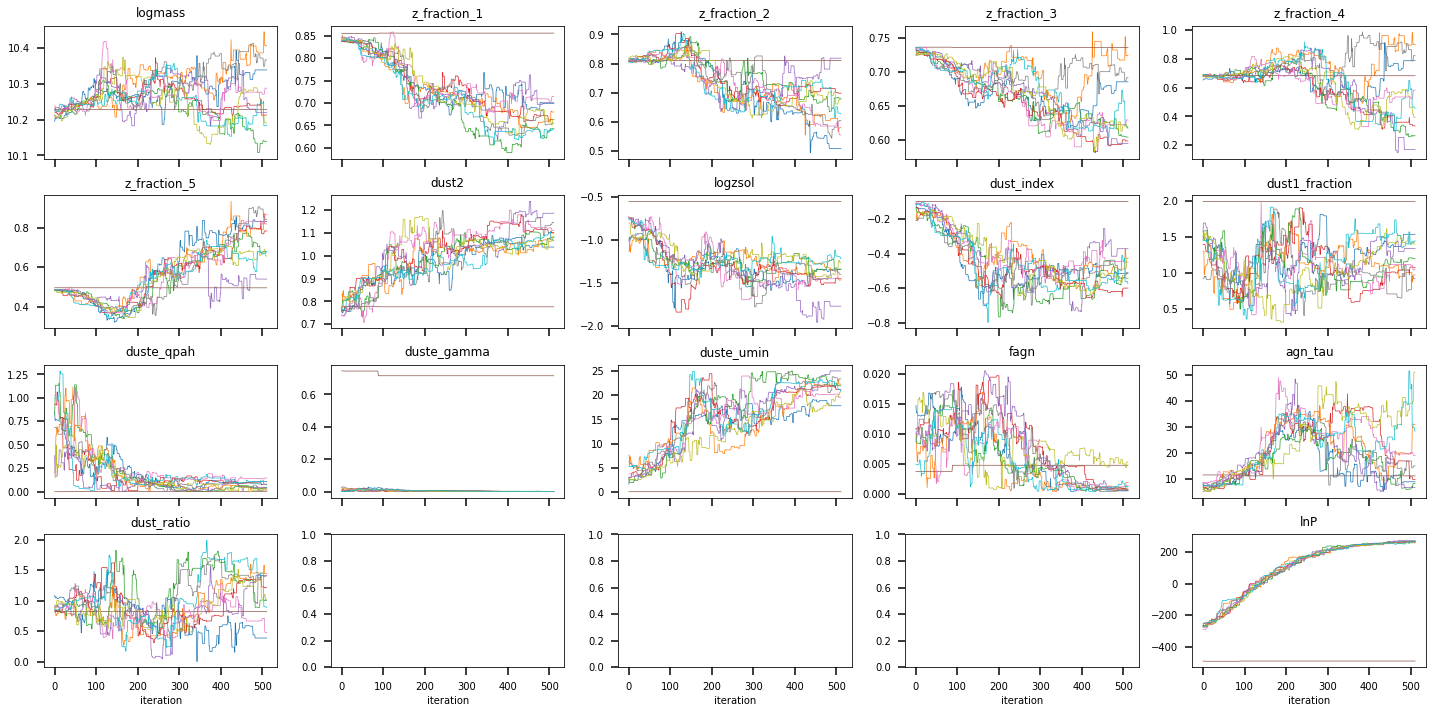

In [30]:
### Plotting Parameter Traces ###
chosen = np.random.choice(result["run_params"]["nwalkers"], size=10, replace=False)
tracefig = reader.traceplot(result, figsize=(20,10), chains=chosen)

savefig(Galaxy_Path + 'G{0}_{1}_{2}_param_trace_4'.format(galaxy_num, Template_Type, ts))

Optimization value: [ 1.00000000e+01  8.33333333e-01  8.00000000e-01  7.50000000e-01
  6.66666667e-01  5.00000000e-01  3.00000000e-01 -5.00000000e-01
  0.00000000e+00  1.00000000e+00  3.00000000e+00  1.00000000e-02
  1.00000000e+00  1.00000000e-04  5.00000000e+00  1.00000000e+00]
MAP value: [ 1.03238318e+01  6.52210680e-01  5.37987512e-01  7.06512569e-01
  8.36949135e-01  7.87070139e-01  1.09603820e+00 -1.26947716e+00
 -4.83033114e-01  9.61586198e-01  3.97007049e-02  5.45448758e-04
  2.17958621e+01  3.76719794e-04  1.68571460e+01  1.04694018e+00]


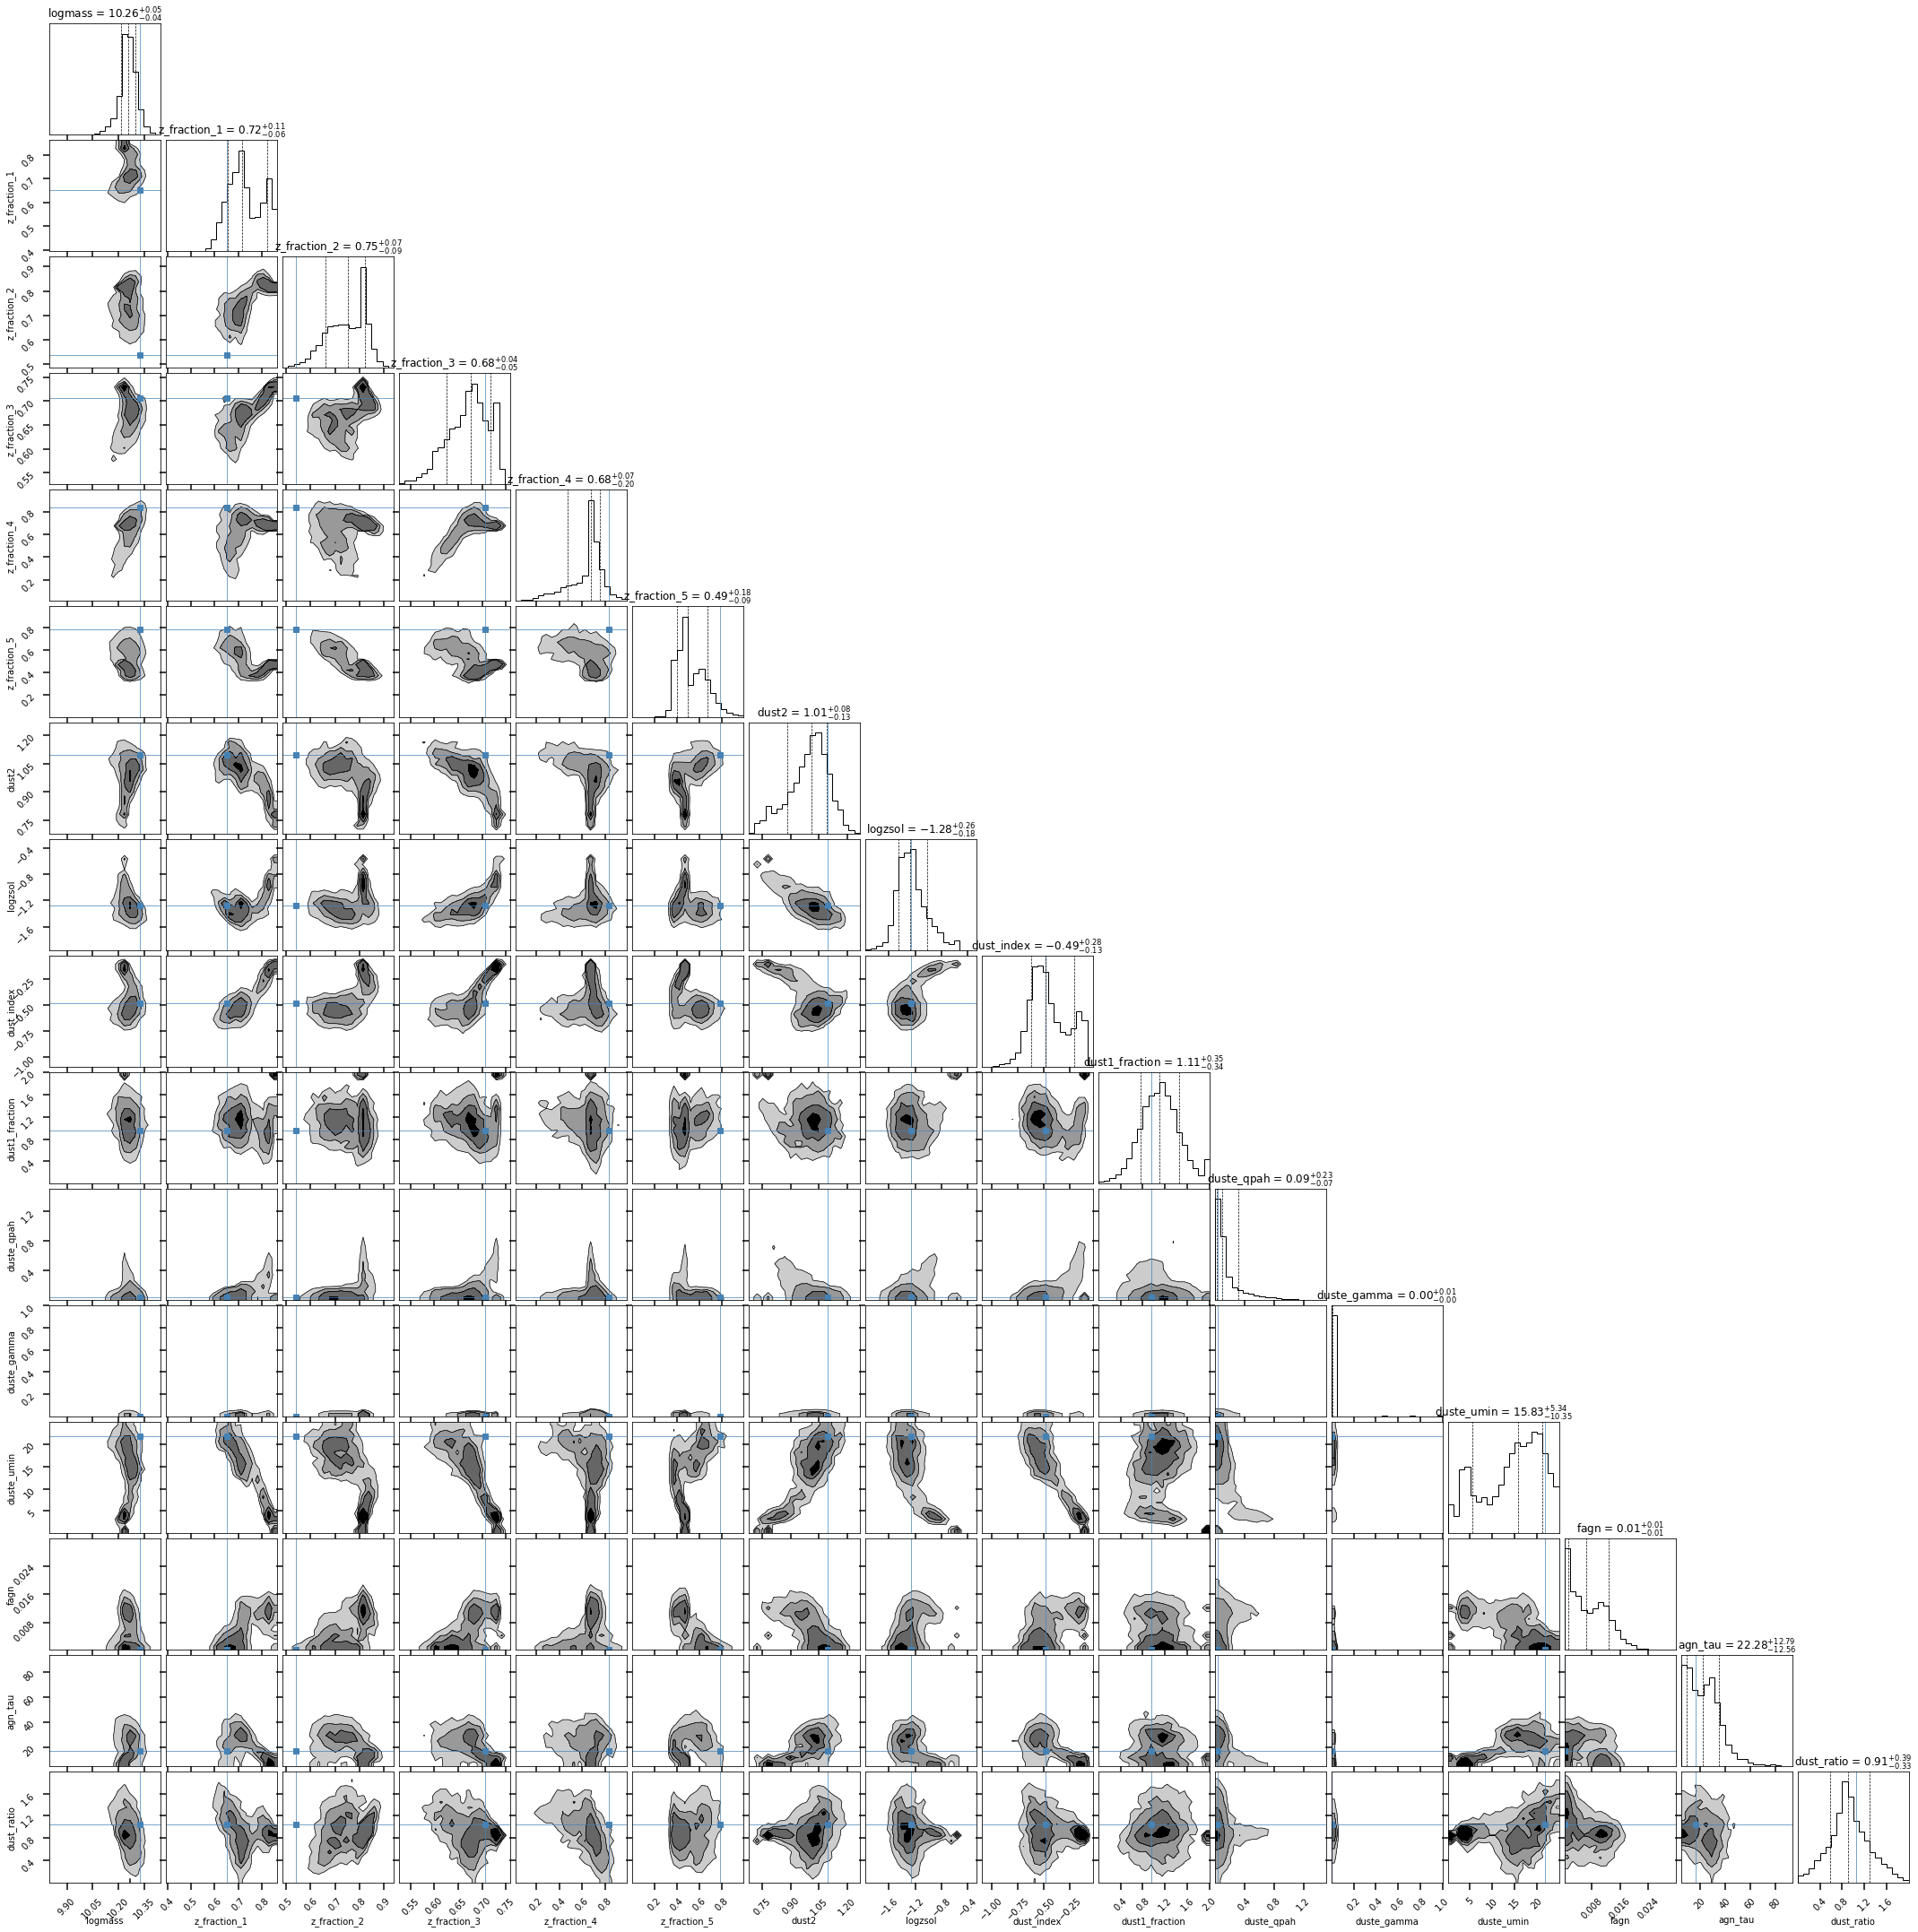

In [31]:
### Corner Plot ###
# Maximum a posterior (of the locations visited by the MCMC sampler)
imax = np.argmax(result['lnprobability'])
i, j = np.unravel_index(imax, result['lnprobability'].shape)
theta_max = result['chain'][i, j, :].copy()
thin = 5

print('Optimization value: {}'.format(theta_best))
print('MAP value: {}'.format(theta_max))

cornerfig = reader.subcorner(result, start=0, thin=thin, truths= result['bestfit']['parameter'],  
                        fig=subplots(16,16,figsize=(30,30))[0])       # MUST modify subplot(#,#)

savefig(Galaxy_Path + 'G{0}_{1}_{2}_corner_plot_5'.format(galaxy_num, Template_Type, ts))

In [32]:
### Create a table of prediction parameters and bestfit parameters ###
pandas.DataFrame([theta_best, result['bestfit']['parameter']], index=['prediction', 'bestfit'], columns=result['theta_labels']).T

prediction    bestfit
logmass          10.000000  10.323832
z_fraction_1      0.833333   0.652211
z_fraction_2      0.800000   0.537988
z_fraction_3      0.750000   0.706513
z_fraction_4      0.666667   0.836949
z_fraction_5      0.500000   0.787070
dust2             0.300000   1.096038
logzsol          -0.500000  -1.269477
dust_index        0.000000  -0.483033
dust1_fraction    1.000000   0.961586
duste_qpah        3.000000   0.039701
duste_gamma       0.010000   0.000545
duste_umin        1.000000  21.795862
fagn              0.000100   0.000377
agn_tau           5.000000  16.857146
dust_ratio        1.000000   1.046940

In [33]:
# https://github.com/nolaaa/SED_fitting_Prospecotr/blob/master/7_run_prospector_for_all_arcs.ipynb

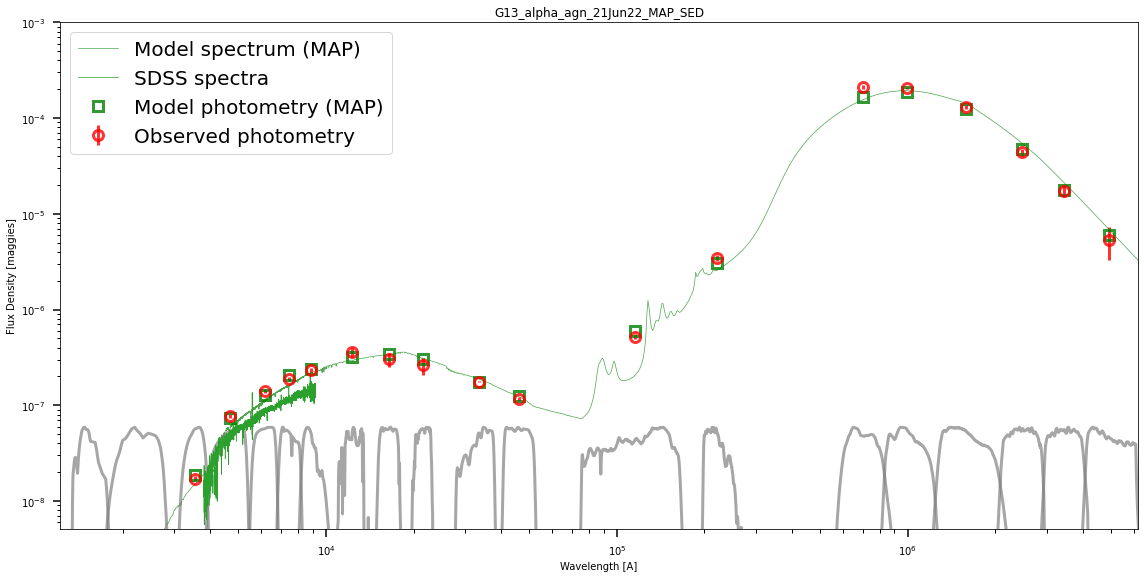

In [34]:
# https://github.com/bd-j/prospector/issues/186

### Plot generated bestfit SED model ###
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

# Make plot of data and model
figure(figsize=(16,8))

loglog(wspec * (1 + model.params['zred']), mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Plot optical and IRS data if available
plot(optical_spectrum_lam, optical_spectrum_flux, label='SDSS spectra')
if IRS_indicator == 1:
    plot(IRS_wavelength, IRS_flux, label='IRS spectra')

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()
title('G{0}_{1}_{2}_MAP_SED'.format(galaxy_num, Template_Type, ts))

savefig(Galaxy_Path + 'G{0}_{1}_{2}_MAP_SED_6'.format(galaxy_num, Template_Type, ts))

In [35]:
### Print time it takes to run full program ###
end_time = time.time()
print("this program takes:", end_time - start_time, "seconds to run")
print("this program takes:", (end_time - start_time)/60, "minutes to run")

this program takes: 3266.7525186538696 seconds to run
this program takes: 54.445875310897826 minutes to run


In [36]:
# result['bestfit'] #https://github.com/bd-j/prospector/issues/215